<a href="https://colab.research.google.com/github/krmonline/PII/blob/main/%E0%B8%8A%E0%B8%B7%E0%B9%88%E0%B8%AD%E0%B8%84%E0%B8%99.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
!pip install pythainlp==3.0.0
!pip install python-crfsuite
!pip  install  deepcut

     |████████████████████████████████| 11.5 MB 9.2 MB/s 
  Attempting uninstall: pythainlp
    Found existing installation: pythainlp 3.0.3
    Uninstalling pythainlp-3.0.3:
      Successfully uninstalled pythainlp-3.0.3


In [2]:
from bs4 import BeautifulSoup
import requests
import pickle
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
!pip install faker

     |████████████████████████████████| 1.1MB 5.2MB/s 


ทำการแปลง Character เป็น Array ต้นฉบับมาจากอาจารย์เอกพล
https://github.com/ekapolc/nlp_course/blob/master/HW1/Word_Tokenizer_Lab.ipynb

และ มีการจัดการกับ Out Of Vocab โดยที่คำที่เราไม่รู้จักให้ไปลงที่  "\ufeff"



In [3]:
CHARS = [
  '\n', ' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+',
  ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8',
  '9', ':', ';', '<', '=', '>', '?', '@', 'A', 'B', 'C', 'D', 'E',
  'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R',
  'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', '\\', ']', '^', '_',
  'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm',
  'n', 'o', 'other', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y',
  'z', '}', '~', 'ก', 'ข', 'ฃ', 'ค', 'ฅ', 'ฆ', 'ง', 'จ', 'ฉ', 'ช',
  'ซ', 'ฌ', 'ญ', 'ฎ', 'ฏ', 'ฐ', 'ฑ', 'ฒ', 'ณ', 'ด', 'ต', 'ถ', 'ท',
  'ธ', 'น', 'บ', 'ป', 'ผ', 'ฝ', 'พ', 'ฟ', 'ภ', 'ม', 'ย', 'ร', 'ฤ',
  'ล', 'ว', 'ศ', 'ษ', 'ส', 'ห', 'ฬ', 'อ', 'ฮ', 'ฯ', 'ะ', 'ั', 'า',
  'ำ', 'ิ', 'ี', 'ึ', 'ื', 'ุ', 'ู', 'ฺ', 'เ', 'แ', 'โ', 'ใ', 'ไ',
  'ๅ', 'ๆ', '็', '่', '้', '๊', '๋', '์', 'ํ', '๐', '๑', '๒', '๓',
  '๔', '๕', '๖', '๗', '๘', '๙', '‘', '’', '\ufeff'
]
CHARS_MAP = {v: k for k, v in enumerate(CHARS)}

def name2arr(x):
  result = ""
  for i in x:
    if i not in CHARS_MAP:
      i = '\ufeff' #OutOfVocab
    if result == "":
      result = str(CHARS_MAP[i])
    else:
      result = result + "," + str(CHARS_MAP[i])
  return result

ทำการเตรียมชื่อ

In [6]:
df_name1 = pd.read_csv('https://raw.githubusercontent.com/krmonline/PII/main/name.csv')
df_name2 = pd.read_csv('https://raw.githubusercontent.com/krmonline/PII/main/mock_name_address.csv')

In [7]:
df_name2['name'] = df_name2.FName.apply(lambda x: x.split(" ")[0])

In [8]:
arr_name1 = df_name1.name.values
#arr_userdefined = np.array(['สมหมาย','สมชาย','สมเกียรติ','ประเทือง']) #เพิ่มชื่อด้วยตังเองเมื่อเห็นว่าชื่อไม่เคยเทรนมาก่อน
#arr_name1 = np.concatenate([arr_name1,arr_userdefined])

In [9]:
arr_name = np.concatenate([df_name1.name.values,df_name2.name.values])
arr_name = pd.DataFrame(arr_name,columns=['name']).name.unique()
df_name = pd.DataFrame(arr_name,columns=['name'])

In [10]:
df_name[df_name.name == 'สมเกียรติ'] #check ว่าชื่ออยู่ใน data  frame  หรือเปล่า

,name
563,สมเกียรติ


แปลงชื่อมาเป็น Array และกำหนด Label ให้เป็น 1
โดย 1 = เป็นชื่อคน และ 0 = ไม่ใช่ชื่อคน
เราจะได้ Array ซึ่งเป็นค่า key ของแต่ละ Character

In [11]:
df_name["arr_num"] = df_name.name.apply(name2arr)
df_name['label'] = 1
df_name

,name,arr_num,label
0,กมลภู,"94,126,130,125,149",1
1,กรกวรรษ,"94,128,94,131,128,128,133",1
2,กรณ์,"94,128,112,163",1
3,กฤศ,"94,129,132",1
4,กฤษิกร,"94,129,133,144,94,128",1
...,...,...,...
1006,จักรีรัตน์,"101,141,94,128,145,128,141,114,118,163",1
1007,นารดา,"118,142,128,113,142",1
1008,อาแอเสาะ,"137,142,152,137,151,134,142,140",1
1009,คมกฤชญ์,"97,126,94,129,103,106,163",1


In [12]:
#df_name.to_csv("./name.csv",index=False)

#เตรียมชื่อนามทั่วไป

In [20]:
import pythainlp.word_vector
import random

Corpus: thai2fit_wv
- Downloading: thai2fit_wv 0.1


100%|██████████| 62452646/62452646 [00:02<00:00, 30771182.41it/s]


สุ่มคำจาก word_vector มาจำนวนเท่าๆกับชื่อคนเพื่อเป็น DataSet ของคำที่ไม่่ใช่ชื่อคน

In [25]:
model = pythainlp.word_vector.get_model()
arr_tmp = []
for i  in range(len(df_name)):
  nameID = random.randint(0,2000)
  name = model.index2word[nameID]
  arr_tmp.append(name)
print("Random general word =",len(arr_tmp))
df2 = pd.DataFrame(arr_tmp,columns=['name'])
df2["arr_num"] = df2.name.apply(name2arr) #Check OOV ใน function แล้ว
df2['label'] = 0

Random general word = 1011


#Merge Data

In [26]:
df = pd.concat([df_name,df2])
df.head()

,name,arr_num,label
0,กมลภู,"94,126,130,125,149",1
1,กรกวรรษ,"94,128,94,131,128,128,133",1
2,กรณ์,"94,128,112,163",1
3,กฤศ,"94,129,132",1
4,กฤษิกร,"94,129,133,144,94,128",1


หาค่าจำนวน  Character สูงสุดที่เป็นไปได้และเพิ่มไปอีก 1.5 เท่า
เป็นข้อจำกัดของ LSTM ที่ต้องกำหนดค่าสูงสุดของตัวอักษรในที่นี้คือ maxlen

In [27]:
arr_numID = []
maxlen = 0
n = 0
for i in df.arr_num:
  n = n+1
  #print(n,i)
  arr_tmp = [int(iInt) for iInt in i.split(',')]
  #print(arr_tmp)
  arr_numID.append(arr_tmp)
  #print(i.split(','))
  lentmp = len(arr_numID[-1])
  if maxlen < lentmp:
    maxlen = lentmp
maxlen = int(maxlen*1.5)
print(maxlen)
#ได้ maxlen

22


In [28]:
#arr_numID[:5],df.label.values[:5]

#แบ่ง Train Test

In [29]:
from sklearn.model_selection import train_test_split

ทำ padding ให้กับคำโดยเติม 0 ไปข้างหน้าให้เต็ม เช่น [0,0,0,192,191,176,123]

In [30]:
X = tf.keras.preprocessing.sequence.pad_sequences(
    arr_numID, maxlen=maxlen, dtype='int32', padding='pre',
    truncating='pre', value=0.0
)
y = df.label.values

แบ่ง Dataset  ออกมา 3 ส่วน ประกอบด้วย Train Set,Test Set,Validation Set

In [31]:
X_trainTMP, X_test, y_trainTMP, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_valid, y_train, y_valid = train_test_split(X_trainTMP, y_trainTMP, test_size=0.3, random_state=42)
X_train.shape,y_train.shape,X_valid.shape,y_valid.shape,X_test.shape,y_test.shape,

((1131, 22), (1131,), (486, 22), (486,), (405, 22), (405,))

#Train ด้วย LSTM

In [32]:
vocab_size = len(CHARS)
print(vocab_size)
del(model)
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 1, input_length=maxlen),
    tf.keras.layers.LSTM(1,return_sequences=False),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss=tf.keras.losses.binary_crossentropy,optimizer='adam',metrics=['accuracy'])
model.summary()
loss = []
val_loss = []
acc = []
val_acc = []

178
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 22, 1)             178       
                                                                 
 lstm (LSTM)                 (None, 1)                 12        
                                                                 
 dense (Dense)               (None, 1)                 2         
                                                                 
Total params: 192
Trainable params: 192
Non-trainable params: 0
_________________________________________________________________


In [33]:
%%time
history_tmp = model.fit(X_train,y_train,epochs=100,validation_data=(X_valid,y_valid),verbose=1)

Epoch 1/100
36/36 [==============================] - 3s 26ms/step - loss: 0.6922 - accuracy: 0.5659 - val_loss: 0.6909 - val_accuracy: 0.6646
Epoch 2/100
36/36 [==============================] - 0s 12ms/step - loss: 0.6885 - accuracy: 0.7507 - val_loss: 0.6864 - val_accuracy: 0.7819
Epoch 3/100
36/36 [==============================] - 0s 11ms/step - loss: 0.6827 - accuracy: 0.7843 - val_loss: 0.6788 - val_accuracy: 0.7840
Epoch 4/100
36/36 [==============================] - 0s 11ms/step - loss: 0.6731 - accuracy: 0.7586 - val_loss: 0.6664 - val_accuracy: 0.7346
Epoch 5/100
36/36 [==============================] - 0s 11ms/step - loss: 0.6586 - accuracy: 0.7286 - val_loss: 0.6495 - val_accuracy: 0.7160
Epoch 6/100
36/36 [==============================] - 0s 12ms/step - loss: 0.6414 - accuracy: 0.7330 - val_loss: 0.6322 - val_accuracy: 0.7366
Epoch 7/100
36/36 [==============================] - 0s 11ms/step - loss: 0.6229 - accuracy: 0.7763 - val_loss: 0.6157 - val_accuracy: 0.7840
Epoch 

In [34]:
loss.extend(history_tmp.history['loss'])
val_loss.extend(history_tmp.history['val_loss'])
acc.extend(history_tmp.history['accuracy'])
val_acc.extend(history_tmp.history['val_accuracy'])

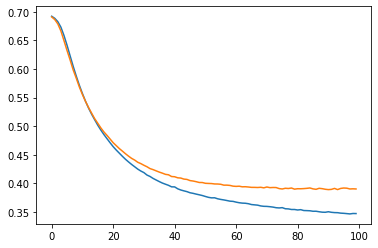

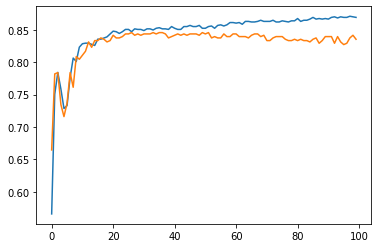

In [35]:
plt.plot(loss)
plt.plot(val_loss)
plt.show()
plt.plot(acc)
plt.plot(val_acc)

ทดสอบ โดยหาชื่อมาลอง Predict ดู

In [36]:
import  numpy as np
name = "รักษา"
arr = [int(i) for i in name2arr(name).split(",")]
dataTest = tf.keras.preprocessing.sequence.pad_sequences(np.array([arr]), maxlen=maxlen, dtype='int32', padding='pre',truncating='pre', value=0.0)
model.predict(dataTest)

array([[0.82044744]], dtype=float32)

#Evaluation

In [37]:
from sklearn import metrics

In [85]:
#pred = model.predict_classes(X_test)
pred = []
for  i  in model.predict(X_test):
  #print(i[0])
  tmp  = 0 if i[0] <  0.8 else  1
  pred.append(tmp)
  #print(tmp)
pred  = np.array(pred)

In [86]:
print(pred)

[1 1 1 0 0 1 0 1 1 0 1 0 1 1 0 0 1 0 0 0 0 1 1 0 1 0 0 0 1 0 0 0 1 1 1 1 0
 0 1 0 1 1 1 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0 1 1 1 0 0 1 1 0 1 0 0 0 1
 1 1 1 1 0 0 0 1 0 0 1 0 0 1 1 0 0 1 0 1 0 0 1 1 1 0 1 1 0 0 0 1 1 1 0 1 1
 1 1 0 1 1 0 0 0 0 0 0 0 1 0 1 0 0 1 0 1 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1
 0 1 0 1 0 1 1 1 0 1 1 1 0 0 1 0 1 1 1 1 1 0 1 0 1 0 1 1 0 1 1 1 1 0 0 0 0
 1 1 1 0 0 1 1 0 1 0 0 0 0 1 1 1 0 0 0 0 0 1 0 0 1 0 1 1 1 1 1 1 0 1 0 0 1
 0 0 0 1 0 0 1 1 0 1 0 1 1 0 0 0 0 0 1 0 1 0 0 0 1 1 1 1 0 1 0 1 0 0 0 1 0
 0 1 0 1 0 1 1 0 1 0 1 0 0 1 1 1 1 0 1 0 1 0 1 1 1 0 0 0 0 1 0 0 1 0 1 0 1
 0 0 1 0 0 0 0 1 1 1 0 1 0 0 0 1 0 0 1 0 1 0 1 1 0 1 0 0 1 0 1 0 0 1 0 0 0
 0 1 1 1 0 0 1 1 1 1 0 1 1 0 0 1 1 0 0 0 1 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0
 0 0 1 0 1 0 0 0 1 0 0 0 1 1 1 0 1 0 1 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0 1]


In [87]:
print(metrics.classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.72      0.83      0.77       193
           1       0.82      0.71      0.76       212

    accuracy                           0.77       405
   macro avg       0.77      0.77      0.77       405
weighted avg       0.78      0.77      0.77       405



In [88]:
#pred = model.predict(X_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test,pred)

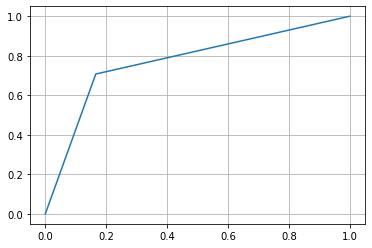

In [89]:
plt.grid()
plt.plot(fpr,tpr)

In [108]:
#text = "ตำรวจจับกุมชายผู้ก่อเหตุทำร้าย ชิงทรัพย์ และพยายามทำอนาจาร นศ.หญิงไทยที่สถานีรถไฟใต้ดินนิวยอร์กได้แล้ว พบประวัติโชกโชน เคยถูกจับมาแล้วถึง 44 ครั้งสำนักข่าว เดลี่เมล รายงานว่า นาย เควิน ดักลาส ชาวเขตควีนส์ อายุ 40 ปี ถูกตำรวจนิวยอร์กจับกุมตัวเมื่อวันพฤหัสบดีที่ 10 ก.พ. 2565 ที่ผ่านมา ในฐานะผู้ต้องหาก่อเหตุทำร้ายร่างกายนักศึกษาและนางแบบสาวชาวไทยวัย 23 ปี ระหว่างที่เธอกำลังรอรถไฟใต้ดินในย่านมิดทาวน์ ในวันที่ 22 พ.ย. ปีก่อนภาพจากกล้องวงจรปิดแสดงให้เห็นว่า ในวันเกิดเหตุ นายดักลาสล็อกคอลากนักศึกษาหญิงไทยไปตามทางเดิน ก่อนจะจับเธอลงกับพื้น จากนั้นจึงชกหน้าหลายครั้ง แล้วชิงกระเป๋าเงินและเดินจากไปอย่างรวดเร็วแต่หลังจากเกิดเหตุการณ์นี้ไม่กี่ชั่วโมง นายดักลาสก็บุกเข้าไปในบ้านของหญิงวัย 34 ปีคนหนึ่ง ก่อนจะชกเธอเข้าที่ใบหน้า ทำให้เขาถูกจับกุมและถูกคุมขังนับแต่นั้น กระทั่งตำรวจสืบจนพบว่า เขาเป็นผู้ก่อเหตุทำร้ายนักศึกษาหญิงไทยด้วย จึงดำเนินการจับกุมซ้ำอีกครั้งในวันพฤหัสบดี"
text  = "บรรณรงค์ พิชญากร กรรมการผู้จัดการอาวุโส กิจการค้าหลักทรัพย์ บริษัทหลักทรัพย์ (บล.) บัวหลวง จำกัด (มหาชน) กล่าวว่า ปัจจุบันเทคโนโลยีได้เข้ามามีบทบาทในไลฟ์สไตล์ผู้คนมากขึ้น โดยเฉพาะช่วงการระบาดของโควิดราว 2 ปีที่ผ่านมา หลายๆ อย่างโดยเฉพาะเทคโนโลยีเร่งตัวเพิ่มขึ้นเพราะโควิด แต่การระบาดของโรคก็ทำให้ผู้คนจำนวนหนึ่งต้องกลายเป็นคนว่างงาน หรือมีผู้คนอีกจำนวนหนึ่งต้องมองหางานที่สอง หรือจ๊อบเสริมเพิ่มขึ้นจากงานเดิมที่ทำอยู่"

In [109]:
arr2  = pythainlp.word_tokenize(text,engine="deepcut")

In [110]:
arr3  = []
for i in  arr2:
  name = i
  arr = [int(i) for i in name2arr(name).split(",")]
  arr3.append(arr)
dataTest = tf.keras.preprocessing.sequence.pad_sequences(np.array(arr3), maxlen=maxlen, dtype='int32', padding='pre',truncating='pre', value=0.0)
result =  model.predict(dataTest) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


In [112]:
for   i in range(len(result)):
  if result[i]  >  0.8:
    print(result[i],arr2[i])

[0.9153385] บรรณรงค์ พิชญากร
[0.90155876] กรรมการ
[0.9079007] กิจการ
[0.9168997] หลักทรัพย์
[0.9241358] บริษัทหลักทรัพย์
[0.8039799] บล.) บัวหลวง จำกัด (มหาชน)
[0.8353679] ปัจจุบัน
[0.90794384] ไลฟ์สไตล์
